## The battle of neighborhood - NYC- Indian Restaurants

## Contents

1) Introduction/Business Problem
2) Data Sources, Gathering & Cleansing
3) Data Feature Selections
4) Methodology
5) Data Preparation Choices
6) Discussions 
7) Conclusion 

## Introduction

### Introduction / Business Problem
Mark an Investor is looking to start a new Indian restaurant in New York City a major metropolitan area with more than 8.4 million people living within city limits New York City is home to approximately 315,000 people from the Indian subcontinent.

The investor is interested in firstly finding out the best location(s) for Indian cuisine in New York City, in what Neighborhood and/or borough the restaurant will have the best chance of being successful.  

Secondly the investor is looking to understand the different restaurants such as Chinese, Mexican, French, etc around the neighborhood 

### Data Sources, Gathering & Cleansing 
This section describes the data sourced for this project, as well as the data cleansing and preparation for
Subsequent exploration.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

All data related to locations and quality of Indian restaurants will be obtained via the Foursquare API utilized via the request library in Python.

### Methodology

• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a data frame.

• Foursquare be used to locate all venues and then filtered by Italian restaurants. Ratings, tips, and likes by users will be counted and added to the data frame.

• Data will be sorted based on rankings

• Finally, the data be will be visually assessed using graphing from various Python libraries.

Data Preparation & histograms of neighborhoods 

Using: https://cocl.us/new_york_dataset 



In [ ]:
import pandas as pd
!pip -q install beautifulsoup4
from bs4 import BeautifulSoup
import requests
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe
!pip -q install folium 
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans


# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

In [10]:
import json 
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Data downloaded!


In [11]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [12]:
CLIENT_ID = '0WLT3NVVYX2GAEARRVPQWRY2QBKT5EOTNJW4YQE3U35PGHTP' 
CLIENT_SECRET = 'RIHQTZS2BGLU5305RS3WGNI25A4XGTYATZRCTY2ZRQPZVNQT'
VERSION = '20180604'

In [13]:
CLIENT_ID = '0WLT3NVVYX2GAEARRVPQWRY2QBKT5EOTNJW4YQE3U35PGHTP' 
CLIENT_SECRET = 'RIHQTZS2BGLU5305RS3WGNI25A4XGTYATZRCTY2ZRQPZVNQT'
VERSION = '20180604'

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [14]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [16]:
ny_data.shape

(306, 4)

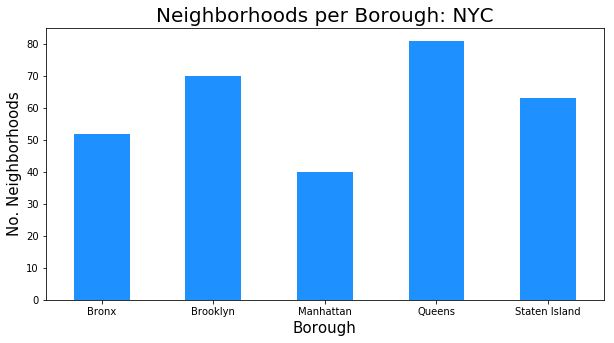

In [18]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [19]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(ny_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    print(row)
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
['Bronx', 'Norwood',

In [22]:
indian_rest_ny.to_csv('indian_rest_ny_tocsv1.csv')

In [23]:
indian_rest_ny = pd.read_csv('indian_rest_ny_tocsv1.csv')
indian_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
28,28,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant
29,29,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine
30,30,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux
31,31,Manhattan,Flatiron,52a1fa08498ede15b1530912,Deep Indian Kitchen (Indikitch)
32,32,Queens,Sunnyside Gardens,4c48da9f3013a59356c5f0e1,Saffron Garden


In [24]:
indian_rest_ny.shape

(33, 5)

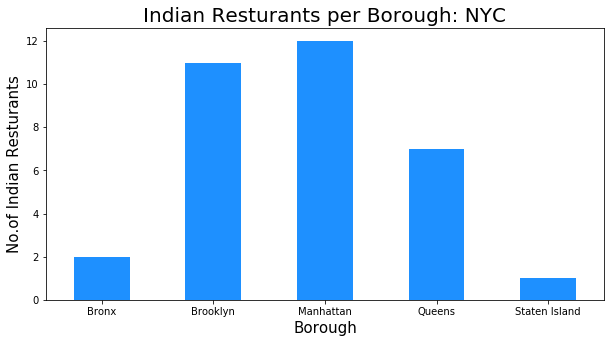

In [25]:
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Indian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Indian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

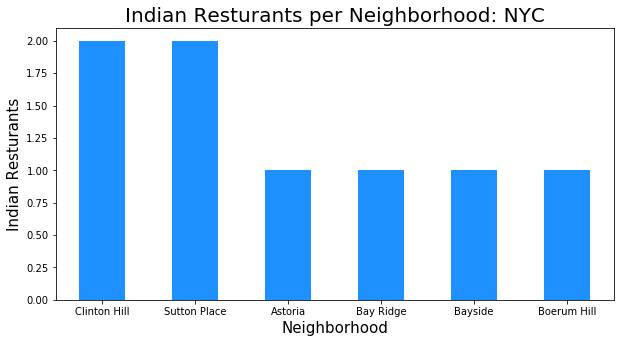

In [27]:
NOofNeigh = 6 # top number for graphing all the same past 6
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Indian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [28]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Clinton Hill']

,Unnamed: 0,Borough,Neighborhood,ID,Name
8,8,Brooklyn,Clinton Hill,568d3902498e619efcbc3f58,Spice & Grill
9,9,Brooklyn,Clinton Hill,4ace7c86f964a520d3d020e3,Kinara's


In [29]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in indian_rest_ny.values.tolist():
    Unnamed,Borough,Neighborhood,ID,Name,=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_stats_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
indian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5e9fd4c4df2774001bcacdd8'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': '?', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primar

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
28,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant,10,7.3,6
29,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine,155,8.4,58
30,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux,186,8.4,83
31,Manhattan,Flatiron,52a1fa08498ede15b1530912,Deep Indian Kitchen (Indikitch),682,8.4,133
32,Queens,Sunnyside Gardens,4c48da9f3013a59356c5f0e1,Saffron Garden,17,7.6,16


In [30]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny_csv.csv')

In [31]:
indian_rest_stats_ny.shape

(33, 7)

In [32]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 7 columns):
Borough         33 non-null object
Neighborhood    33 non-null object
ID              33 non-null object
Name            33 non-null object
Likes           33 non-null object
Rating          33 non-null float64
Tips            33 non-null object
dtypes: float64(1), object(6)
memory usage: 1.9+ KB


In [33]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 7 columns):
Borough         33 non-null object
Neighborhood    33 non-null object
ID              33 non-null object
Name            33 non-null object
Likes           33 non-null float64
Rating          33 non-null float64
Tips            33 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.9+ KB


In [34]:
indian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,33.000000,33.000000,33.000000
mean,106.757576,7.487879,33.848485
std,199.275568,1.617049,52.939306
min,0.000000,0.000000,0.000000
25%,14.000000,7.300000,8.000000
50%,32.000000,7.700000,16.000000
75%,81.000000,8.400000,29.000000
max,834.000000,9.100000,259.000000


In [35]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.7
Tips                                 259
Name: 17, dtype: object

In [37]:
# Resturant with maximum Ratings
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               9.1
Tips                                 148
Name: 20, dtype: object

In [38]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.7
Tips                                 259
Name: 17, dtype: object

In [39]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
26,Tribeca,9.1
20,Noho,8.8
6,Chelsea,8.7
18,Midtown,8.7
9,Fort Greene,8.7
22,Prospect Lefferts Gardens,8.6
21,North Side,8.5
25,Sutton Place,8.4
8,Flatiron,8.4
12,Greenwich Village,8.4


In [40]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.266667
4,Staten Island,8.100000
1,Brooklyn,7.400000
0,Bronx,7.150000
3,Queens,6.300000


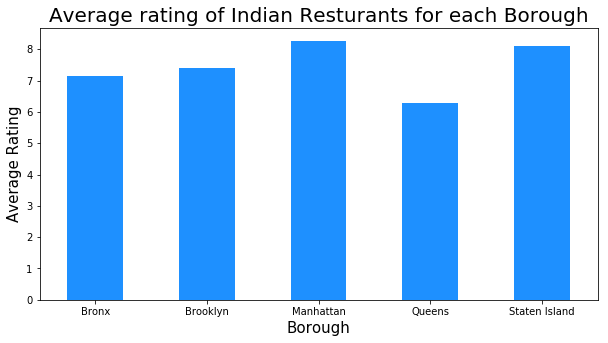

In [41]:
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Indian Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [42]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Bayside,8.2
6,Chelsea,8.7
8,Flatiron,8.4
9,Fort Greene,8.7
12,Greenwich Village,8.4
18,Midtown,8.7
19,New Dorp,8.1
20,Noho,8.8
21,North Side,8.5
22,Prospect Lefferts Gardens,8.6


In [43]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Bayside,40.766041,-73.774274,8.2
1,Manhattan,Chelsea,40.744035,-74.003116,8.7
2,Staten Island,Chelsea,40.594726,-74.189560,8.7
3,Manhattan,Flatiron,40.739673,-73.990947,8.4
4,Brooklyn,Fort Greene,40.688527,-73.972906,8.7
5,Manhattan,Greenwich Village,40.726933,-73.999914,8.4
6,Manhattan,Midtown,40.754691,-73.981669,8.7
7,Staten Island,New Dorp,40.572572,-74.116479,8.1
8,Manhattan,Noho,40.723259,-73.988434,8.8
9,Brooklyn,North Side,40.714823,-73.958809,8.5


In [51]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [60]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

### Results
For K- means Clustering kinldy refer my Project Link : The battle of neighborhood - NYC -https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/5b8cd2cc-0e6b-4187-9a30-b72ea8b9ff5e/view?access_token=4cf6bf3918b07a51b6c3169f69fcfb1c6676a5a85b6d8beaad0b7ca5c9313c9d

### Discussion Recommendations

Finally, the most common venues across the four show some variety as observed in table 1 above. The
Top three most common venues share some similar venue categories, but none share exactly the same
Pattern. For example, Mexican cuisine is ranked first in cluster one,

The venue data – both the top three venue categories in the summary table above, as well as the top
Ten given in the detail charts in the workbook – offer valuable insights into market penetration options.
Depending on the type of venue and market penetration strategy, entrepreneurs investors can choose to align
With direct competitors operating in the same category 

### Conclusion
The restaurant industry is challenged with balancing a variety of demand factors that sometimes
compete, for example genuinely healthy and organic foods and low cost. Restaurateurs and other
stakeholders can use these data analyses and insights presented in this project to explore how to
effectively target new venue locations and effectively service the demand as a final all of the above analyses is depended on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.
